## T2.1 - Simulating N independent particles

The objective of this tutorial is to write a simple molecular dynamics (MD) simulation of multiple, identical simple harmonic oscillators, explore their characteristics (especially kinetic energy), and then how different thermostats affect this.

Our system will be comprised of $N$ identical simple harmonic oscillators starting at different initial positions and momenta

$$H(p,x) = \sum_{i = 1}^{N} \frac{p_i^2}{2m} + \frac{k x_i^2}{2},$$

where $m$ is the mass and $k$ is the spring constant and are kept constant for all oscillators. This leads to Hamilton's equations of motion,

$$\dot{x_i} = \frac{\partial H}{\partial p_i} = \frac{p_i}{m}$$

$$\dot{p_i} = - \frac{\partial H}{\partial x_i} = - k x_i.$$

We know how to solve each of these equations of motion with a Velocity-verlet integrator.

We will need to do the following for an MD program:
* Initialize the particles with some positions and momenta.
* Keep track of the position and momentum of each particle at every time step (the trajectory)
* Evolve the positions and momenta via the Velocity-verlet algorithm.
* Apply a thermostat (if needed).

In [1]:
using Revise;
using Plots;
using LaTeXStrings;
using Random;
using Distributions;
Random.seed!(1234);
# Set up common variables
t_end = 10.0;
dt = 0.01;
N = 10;
Nt = Int(ceil(t_end/dt));
m = 1.0;
k = 1.0;
kT = 1.0;
# Set up global position and momentum vectors
X = zeros(Nt,N);
P = zeros(Nt,N);
Ekin = zeros(Nt);
Epot = zeros(Nt);
Etot = zeros(Nt);
kT_measured = zeros(Nt);

In [2]:
# Initialize the system. The dot notation is element-wise subtraction for now, and we want a uniform distribution of position and momenta.
# Let's start from zero velocity (momentum).
X[1,:] = (rand(N).-0.5);
MaxwellDistribution = Normal(0.0, kT/m);
P[1,:] = rand(MaxwellDistribution, N);

In [3]:
# Velocity-verlet function
# NOTE: Normally this would have quantities like the energy, pressure, temperature, etc,
#       computed when called
function VelocityVerletSHO(X::Float64, P::Float64, m::Float64, k::Float64, dt::Float64)
    Phalf = P - k*X*dt/2.0;
    Xnew = X + Phalf/m*dt;
    Pnew = Phalf - k*Xnew*dt/2.0;
    return Xnew, Pnew
end

VelocityVerletSHO (generic function with 1 method)

In [4]:
# Evolve the system forward in time
for istep in 1:Nt-1
    # Use velocity verlet on every particle
    for idx in 1:N
        X[istep+1,idx], P[istep+1,idx] = VelocityVerletSHO(X[istep,idx], P[istep,idx], m, k, dt)
    end
end

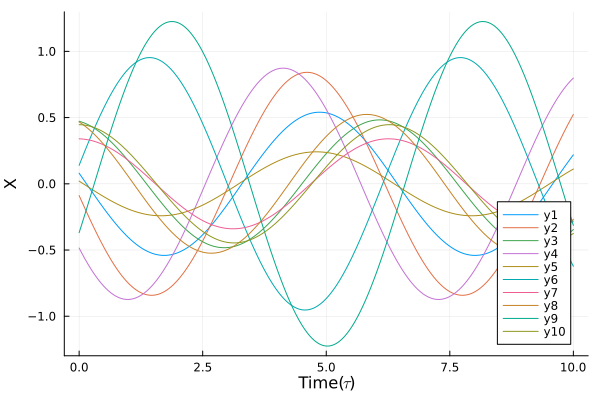

In [5]:
plot(range(0.0, t_end, Nt), X, xlabel = L"""Time($\tau$)""", ylabel = "X")

Now, we want to examine the total energy, and then *kinetic temperature* of the system under study. The kinetic energy is written as

\begin{equation}
E_{\rm kin} = \sum_{i=1}^{N} \frac{1}{2} m v_i(t)^{2}.
\end{equation}

The temperature of this system $T$ can be computed using

\begin{equation}
E_{\rm kin} = \frac{1}{2} N_{\rm df} k_B T,
\end{equation}

in which $N_{\rm df}$ is the number of degrees of freedom **from the kinetic energy**, and $k_B$ is the Boltzmann constant. In MD simulations it is normal to use the quantity $k_B T$ to describe the total energy / temperature of the system. $N_{\rm df}$ can be computed by

\begin{equation}
N_{\rm df} = D N - N_{\rm c} - N_{\rm com}
\end{equation}

in which $D$ is the dimensionality of the problem for the velocity degrees of freedom, $N_{\rm c}$ is the number of constraints in the system (more on this later), and $N_{\rm com}$ is the center-of-mass motion of the system (also more on this later).

In [6]:
# Compute the kinetic energy, potential, energy, and temperature at a given step
function ComputeEnergy(X::Vector{Float64}, P::Vector{Float64}, m::Float64, k::Float64, N::Int, Ndf::Int)
    Ekin = 0.0;
    Epot = 0.0;
    kT = 0.0;
    for idx in 1:N
        Ekin += 0.5 * P[idx] * P[idx] / m;
        Epot += 0.5 * k * X[idx] * X[idx];
    end
    kT = 2.0 * Ekin / Ndf;
    return Ekin, Epot, Ekin+Epot, kT;
end

ComputeEnergy (generic function with 1 method)

In [7]:
for istep in 1:Nt-1
    Ekin[istep], Epot[istep], Etot[istep], kT_measured[istep] = ComputeEnergy(X[istep,:], P[istep,:], m, k, N, N);
end

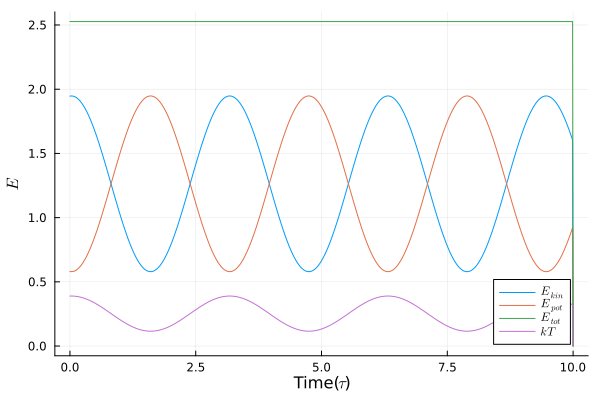

In [8]:
# Plot the energies
Elabels = [L"""$E_{\rm kin}$""" L"""$E_{\rm pot}$""" L"""$E_{\rm tot}$""" L"""$kT$"""];
plot(range(0.0, t_end, Nt), [Ekin, Epot, Etot, kT_measured], xlabel = L"""Time($\tau$)""", ylabel = L"""$E$""", labels=Elabels)

The whole point of using Velocity-verlet is to minimize the error in $E_{\rm tot}$, which we can see for our $N$ particle system, and then we get a constant total energy and temperature (they are related by simple factor for these simulations). Feel free to change $N$ and see how this changes the overall structure of the system. Normally we keep track of the various energy terms at the same time as applying the Velocity-verlet algorithm, especially when thermostatting.

## T2.2 - Velocity rescaling thermostat

The simplest (naive) thermostat simply rescales the velocities at every timestep to make sure that the temperature **trends** towards the target temperature. For instance, if we have a target temperature of $T_0$, then the velocity rescaling algorithm would work as follows.

\begin{align}
v_{new,i} = \lambda v_{old,i} \\
\lambda = \sqrt{\frac{T_0}{T(t)}}
\end{align}

in which the $\lambda$ factor is applied to all of the velocities in the system. However, this does not reproduce the correct **canonical ensemble**, and so we get incorrect statistics of the system. We should see non-Maxwellian velocities of the particles in the system due to this effect. Let's implement it anyway!

First, let's do some bookeeping (technical debt) that we haven't dealt with yet. Create a common structure to hold the simulation state, as well as computed quantities like the temperature.

In [9]:
# Create a structure to hold all of our variables
struct MDSystem
    X::Matrix{Float64};
    P::Matrix{Float64};
    Ekin::Vector{Float64};
    Epot::Vector{Float64};
    Etot::Vector{Float64};
    kT::Vector{Float64};
end
# Create a function to create a default version of this structure
function MDSystem(Nt::Int, N::Int)
    X = zeros(Nt, N);
    P = zeros(Nt, N);
    Ekin = zeros(Nt);
    Epot = zeros(Nt);
    Etot = zeros(Nt);
    kT = zeros(Nt);
    return MDSystem(X, P, Ekin, Epot, Etot, kT);
end

MDSystem

We need to **thermalize** the system, according to the Maxwellian distribution of velocities in 1D.

\begin{equation}
f(v) = \left( \frac{m}{2 \pi k_B T} \right)^{1/2} \exp \left( - \frac{mv^2}{2 k_B T} \right)
\end{equation}

In [10]:
# This will randomize our initial positions
function RandomizeInitialPositions!(mdsys::MDSystem)
    N = size(mdsys.X)[2];
    mdsys.X[1,:] = rand(N) .- 0.5;
    #mdsys.X[1,:] .= 0.0;
end
# This will thermalize the 1D system (assign velocities in a Maxwellian distribution way)
function ThermalizeSystem!(mdsys::MDSystem, m::Float64, kT::Float64)
    N = size(mdsys.X)[2];
    MaxwellDistribution = Normal(0.0, kT/m);
    mdsys.P[1,:] = rand(MaxwellDistribution, N);
end

ThermalizeSystem! (generic function with 1 method)

In [11]:
# Velocity-verlet function for NVE ensemble (to compare to)
function VelocityVerletSHONVE!(mdsys::MDSystem,
        m::Float64,
        k::Float64,
        dt::Float64,
        istep::Int)
    N = size(mdsys.X)[2];
    Ndf = N;
    for idx in 1:N
        Phalf = mdsys.P[istep,idx] - k*mdsys.X[istep,idx]*dt/2.0;
        mdsys.X[istep+1,idx] = mdsys.X[istep,idx] + Phalf/m*dt;
        mdsys.P[istep+1,idx] = Phalf - k*mdsys.X[istep+1,idx]*dt/2.0;
        # Calculate the kinetic energy
        mdsys.Ekin[istep] += 0.5 * mdsys.P[istep,idx] * mdsys.P[istep,idx] / m;
        mdsys.Epot[istep] += 0.5 * k * mdsys.X[istep,idx] * mdsys.X[istep,idx];
    end
    mdsys.Etot[istep] = mdsys.Ekin[istep] + mdsys.Epot[istep];
    # Calculate the Temperature
    mdsys.kT[istep] = 2.0 * mdsys.Ekin[istep] / Ndf;
end

VelocityVerletSHONVE! (generic function with 1 method)

In [12]:
# Velocity-verlet function with naive velocity rescaling
# NOTE: Change the algorithm to work on all particles at the same time, as we need to calculate the energy and
#       the temperature at every timestep
function VelocityVerletSHOVelocityRescale!(mdsys::MDSystem,
        m::Float64,
        k::Float64,
        kT0::Float64,
        dt::Float64,
        istep::Int)
    N = size(mdsys.X)[2];
    Ndf = N;
    for idx in 1:N
        Phalf = mdsys.P[istep,idx] - k*mdsys.X[istep,idx]*dt/2.0;
        mdsys.X[istep+1,idx] = mdsys.X[istep,idx] + Phalf/m*dt;
        mdsys.P[istep+1,idx] = Phalf - k*mdsys.X[istep+1,idx]*dt/2.0;
        # Calculate the kinetic energy
        mdsys.Ekin[istep] += 0.5 * mdsys.P[istep,idx] * mdsys.P[istep,idx] / m;
        mdsys.Epot[istep] += 0.5 * k * mdsys.X[istep,idx] * mdsys.X[istep,idx];
    end
    mdsys.Etot[istep] = mdsys.Ekin[istep] + mdsys.Epot[istep];
    # Calculate the Temperature
    mdsys.kT[istep] = 2.0 * mdsys.Ekin[istep] / Ndf;
    # Rescale all the velocities based on the temperature
    lambda = sqrt(kT0/mdsys.kT[istep]);
    lambda = clamp(lambda, 0.75, 1.25);
    # Apply lambda to all the velocities
    for idx in 1:N
        mdsys.P[istep+1,idx] = lambda * mdsys.P[istep+1,idx];
    end
    return lambda
end

VelocityVerletSHOVelocityRescale! (generic function with 1 method)

In [13]:
# Simulation parameters
Random.seed!(7219);
m = 1.0;
k = 1.0;
kTFake = 1.0; # Original 'temperature'
kT0 = 1.5; # Target temperature
# Set up the system (again), this time with some distribution of initial momenta
InitialValueSim = MDSystem(Nt, N);
NVESim = MDSystem(Nt, N);
VelRescaleSim = MDSystem(Nt, N);
BerendsenSim = MDSystem(Nt, N);
BussiSim0 = MDSystem(Nt, N);
BussiSim1 = MDSystem(Nt, N);
RandomizeInitialPositions!(InitialValueSim);
ThermalizeSystem!(InitialValueSim, m, kTFake);
# Copy the values of X,P from the NVESim
NVESim.X[1,:] = InitialValueSim.X[1,:];
NVESim.P[1,:] = InitialValueSim.P[1,:];
VelRescaleSim.X[1,:] = InitialValueSim.X[1,:];
VelRescaleSim.P[1,:] = InitialValueSim.P[1,:];
BerendsenSim.X[1,:] = InitialValueSim.X[1,:];
BerendsenSim.P[1,:] = InitialValueSim.P[1,:];
BussiSim0.X[1,:] = InitialValueSim.X[1,:];
BussiSim0.P[1,:] = InitialValueSim.P[1,:];
BussiSim1.X[1,:] = InitialValueSim.X[1,:];
BussiSim1.P[1,:] = InitialValueSim.P[1,:];
# Evolve the system forward in time
lambda_velrescale = zeros(Nt);
for istep in 1:Nt-1
    # Use our updated velocity verlet
    VelocityVerletSHONVE!(NVESim, m, k, dt, istep);
    # Compare to the Velocity-rescaled version!
    lambda_velrescale[istep] = VelocityVerletSHOVelocityRescale!(VelRescaleSim, m, k, 1.0, dt, istep);
end

Plot the trajectories and energies for the NVE ensemble.

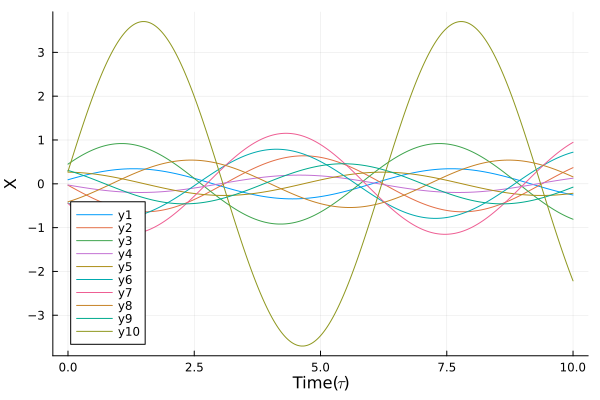

In [14]:
plot(range(0.0, t_end, Nt), NVESim.X, xlabel = L"""Time($\tau$)""", ylabel = "X")

Now let's look at the trajectory and energies of the velocity-rescaling thermostat.

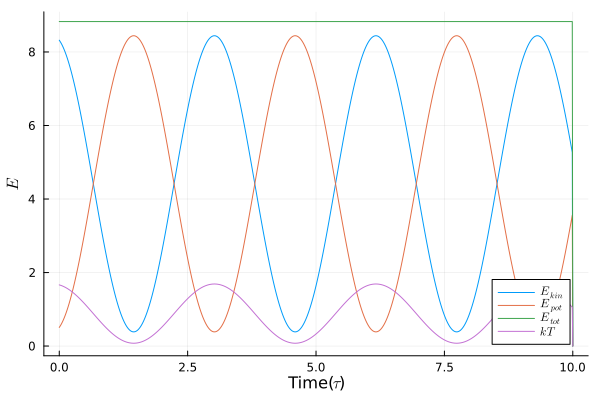

In [15]:
plot(range(0.0, t_end, Nt), [NVESim.Ekin, NVESim.Epot, NVESim.Etot, NVESim.kT], xlabel = L"""Time($\tau$)""", ylabel = L"""$E$""", labels=Elabels)

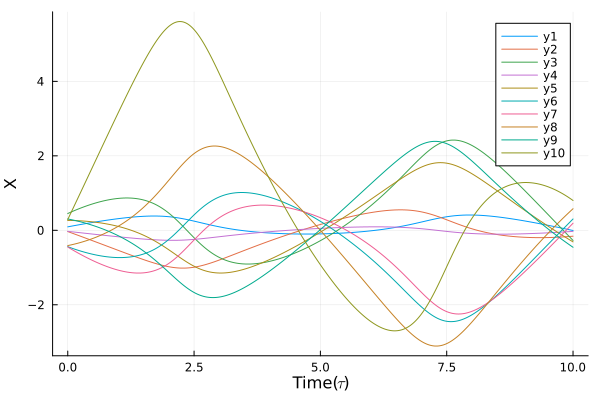

In [16]:
plot(range(0.0, t_end, Nt), VelRescaleSim.X, xlabel = L"""Time($\tau$)""", ylabel = "X")

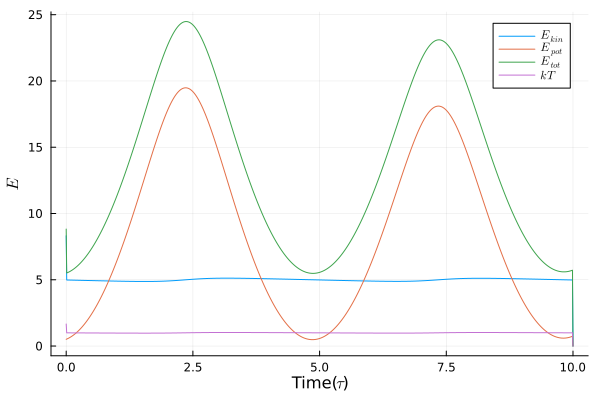

In [17]:
plot(range(0.0, t_end, Nt),
    [VelRescaleSim.Ekin,
        VelRescaleSim.Epot,
        VelRescaleSim.Etot,
        VelRescaleSim.kT],
    xlabel = L"""Time($\tau$)""", ylabel = L"""$E$""", labels=Elabels)

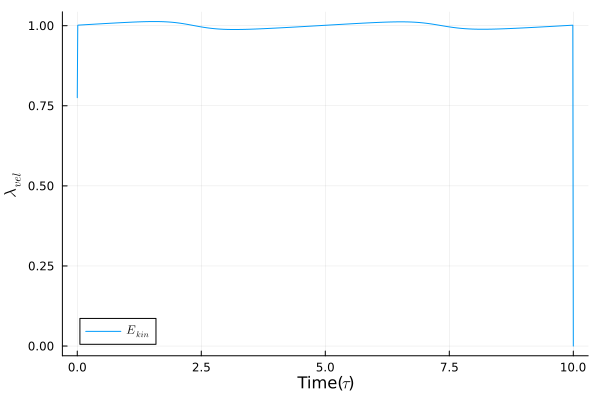

In [18]:
# Plot the lambda rescaling values to see what is going on...
plot(range(0.0, t_end, Nt), lambda_velrescale, xlabel = L"""Time($\tau$)""", ylabel = L"""$\lambda_{\rm vel}$""", labels=Elabels)

## T2.3 - Berendsen thermostat

Naive velocity rescaling thermostats have the problem that they
* does not reproduce the correct canonical ensemble
* very large 'corrections' can occur

A 'softer' version of velocty rescaling is the Beredsen thermostat. We can couple the temperature at time $t$ to a bath temperature via.

\begin{equation}
\frac{\partial T(t)}{\partial t} = \frac{1}{\tau} \left( T_{\rm bath} - T(t) \right)
\end{equation}

in which $\tau$ is a coupling constant describing the strength of the thermostat. Note that this thermostat also does not reproduce the correct canonical ensemble, but is more stable than the strict velocity-rescaling one. We can derive a $\lambda$ scaling parameter from this of

\begin{equation}
\lambda = \sqrt{1 + \frac{\Delta t}{\tau} \left( \frac{T_{\rm bath}}{T(t)} - 1 \right)}
\end{equation}

In [19]:
# Berendsen thermostat
function VelocityVerletSHOBerendsen!(mdsys::MDSystem,
        m::Float64,
        k::Float64,
        kTbath::Float64,
        tau::Float64,
        dt::Float64,
        istep::Int)
    N = size(mdsys.X)[2];
    Ndf = N;
    for idx in 1:N
        Phalf = mdsys.P[istep,idx] - k*mdsys.X[istep,idx]*dt/2.0;
        mdsys.X[istep+1,idx] = mdsys.X[istep,idx] + Phalf/m*dt;
        mdsys.P[istep+1,idx] = Phalf - k*mdsys.X[istep+1,idx]*dt/2.0;
        # Calculate the kinetic energy
        mdsys.Ekin[istep] += 0.5 * mdsys.P[istep,idx] * mdsys.P[istep,idx] / m;
        mdsys.Epot[istep] += 0.5 * k * mdsys.X[istep,idx] * mdsys.X[istep,idx];
    end
    mdsys.Etot[istep] = mdsys.Ekin[istep] + mdsys.Epot[istep];
    # Calculate the Temperature
    mdsys.kT[istep] = 2.0 * mdsys.Ekin[istep] / Ndf;
    # Rescale all the velocities based on the temperature
    lambda = sqrt(1.0 + dt/tau * (kTbath/mdsys.kT[istep] - 1.0));
    lambda = clamp(lambda, 0.75, 1.25);
    # Apply lambda to all the velocities
    for idx in 1:N
        mdsys.P[istep+1,idx] = lambda * mdsys.P[istep+1,idx];
    end
    return lambda
end

VelocityVerletSHOBerendsen! (generic function with 1 method)

In [20]:
# Evolve the system forward in time
BerendsenSim.X[1,:] = InitialValueSim.X[1,:];
BerendsenSim.P[1,:] = InitialValueSim.P[1,:];
tau_berendsen = 1.0;
lambda_berendsen = zeros(Nt);
for istep in 1:Nt-1
    # Compare to the Berendsen thermostat
    lambda_berendsen[istep] = VelocityVerletSHOBerendsen!(BerendsenSim, m, k, 1.0, tau_berendsen, dt, istep);
end

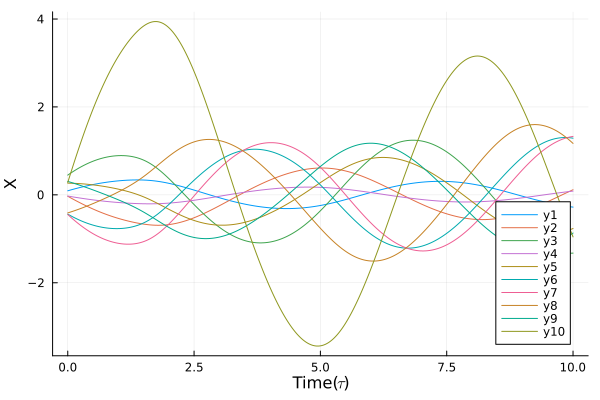

In [21]:
plot(range(0.0, t_end, Nt), BerendsenSim.X, xlabel = L"""Time($\tau$)""", ylabel = "X")

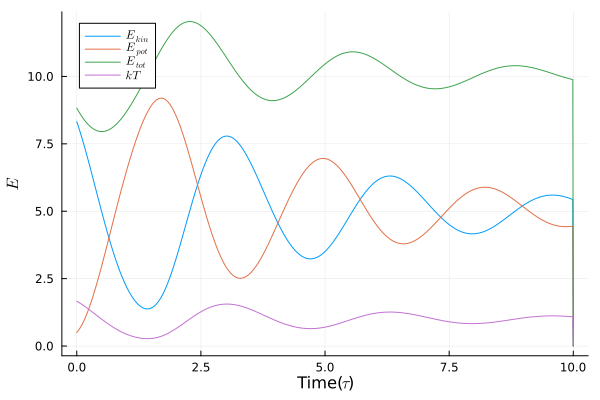

In [22]:
plot(range(0.0, t_end, Nt),
    [BerendsenSim.Ekin,
        BerendsenSim.Epot,
        BerendsenSim.Etot,
        BerendsenSim.kT],
    xlabel = L"""Time($\tau$)""", ylabel = L"""$E$""", labels=Elabels)

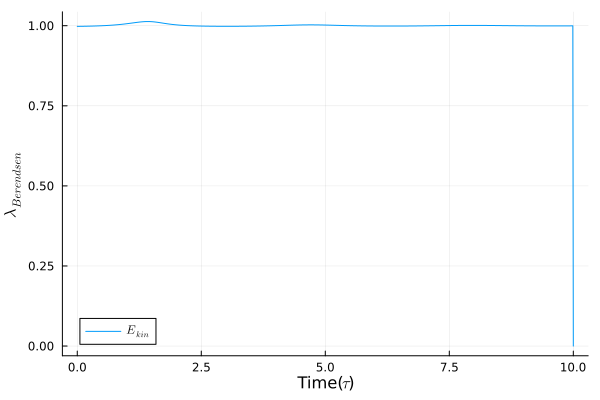

In [23]:
# Plot the lambda rescaling values to see what is going on...
plot(range(0.0, t_end, Nt), lambda_berendsen, xlabel = L"""Time($\tau$)""", ylabel = L"""$\lambda_{\rm Berendsen}$""", labels=Elabels)

## T2.4 - Bussi-Donadio-Parrinello thermostat

This thermostat uses stochastic velocity rescaling, in essence, combining the Berendsen thermostat with a stochastic term. This allows the thermostat to **properly sample a canonical ensemble.**

\begin{equation}
dK = (K_0 - K)\frac{\Delta t}{\tau_T} + 2 \sqrt{\frac{K K_0}{N_{\rm df} \tau_T}} dW
\end{equation}

in which $K$ is the kinetic energy, $N_{\rm df}$ is the number of degrees of freedom, and $dW$ is a Wiener process (you're going to throw a gaussian random number). The derivation of this is rather involved, but in the end, we wind up constructing a parameter $\alpha(t)$ that rescales the velocities of every particle. After a bunch of algebra that I don't fully understand, you can write down the value for $\alpha$ of (dear god)

\begin{equation}
\alpha = \sqrt{e^{\Delta t/\tau} + \left(1 - e^{\Delta t/\tau} \right)
\frac{(2 g_{N-1} + n^2)kT}{2K} + 2n\sqrt{e^{\Delta t/\tau}(1-e^{\Delta t/\tau})\frac{kT}{2K}}}
\end{equation}

in which $n$ is a random value sampled from the normal distribution, $g_N$ is sampled from the distribution Gamma(N,1), and $\tau$ is a decay parameter. When $\tau$ = 0, then $\alpha$ becomes much simpler

\begin{equation}
\alpha = \sqrt{\frac{g_N kT}{K}}
\end{equation}

In [24]:
# Bussi thermostat
function VelocityVerletSHOBussi!(mdsys::MDSystem,
        m::Float64,
        k::Float64,
        kT::Float64,
        tau::Float64,
        dt::Float64,
        istep::Int)
    N = size(mdsys.X)[2];
    Ndf = N;
    for idx in 1:N
        Phalf = mdsys.P[istep,idx] - k*mdsys.X[istep,idx]*dt/2.0;
        mdsys.X[istep+1,idx] = mdsys.X[istep,idx] + Phalf/m*dt;
        mdsys.P[istep+1,idx] = Phalf - k*mdsys.X[istep+1,idx]*dt/2.0;
        # Calculate the kinetic energy
        mdsys.Ekin[istep] += 0.5 * mdsys.P[istep,idx] * mdsys.P[istep,idx] / m;
        mdsys.Epot[istep] += 0.5 * k * mdsys.X[istep,idx] * mdsys.X[istep,idx];
    end
    mdsys.Etot[istep] = mdsys.Ekin[istep] + mdsys.Epot[istep];
    # Calculate the Temperature
    mdsys.kT[istep] = 2.0 * mdsys.Ekin[istep] / Ndf;
    # Calculate the form of alpha to use
    alpha = 1.0;
    # Yes I know this isn't efficient, should just create once for the whole system based on N
    if tau <= 0.0
        GammaDistributionN = Gamma(Ndf, 1);
        gN = rand(GammaDistributionN, 1)[1];
        alpha = sqrt(gN * kT/mdsys.Ekin[istep])
    else
        n = randn(1)[1];
        GammaDistributionNm1 = Gamma(Ndf-1, 1);
        gNm1 = rand(GammaDistributionNm1, 1)[1];
        expdttau = exp(-dt/tau);
        term1 = expdttau;
        term2 = (1.0 - expdttau)*(2*gNm1 + n^2)*kT/(2*mdsys.Ekin[istep]);
        term3 = 2*n*sqrt(expdttau*(1.0 - expdttau)*kT/(2*mdsys.Ekin[istep]));
        alpha = sqrt(term1 + term2 + term3);
    end
    # Apply alpha to all the velocities
    for idx in 1:N
        mdsys.P[istep+1,idx] = alpha * mdsys.P[istep+1,idx];
    end
    return alpha
end

VelocityVerletSHOBussi! (generic function with 1 method)

In [25]:
# Evolve the system forward in time
BussiSim0.X[1,:] = InitialValueSim.X[1,:];
BussiSim0.P[1,:] = InitialValueSim.P[1,:];
tau_bussi = 0.0;
alpha_bussi0 = zeros(Nt);
# Make this consistent by setting a random seed every time we evaluate this cell!
Random.seed!(71298);
for istep in 1:Nt-1
    # Compare to the Berendsen thermostat
    alpha_bussi0[istep] = VelocityVerletSHOBussi!(BussiSim0, m, k, 1.0, tau_bussi, dt, istep);
end

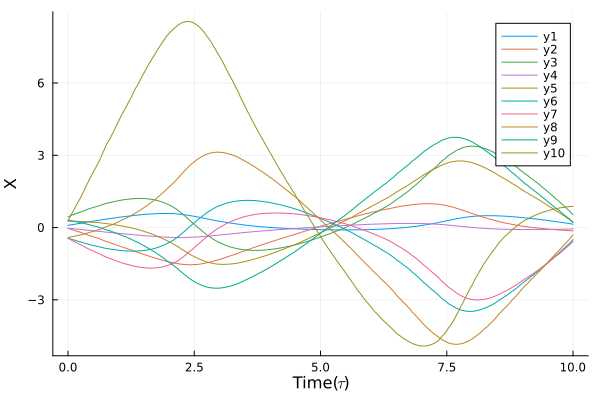

In [26]:
plot(range(0.0, t_end, Nt), BussiSim0.X, xlabel = L"""Time($\tau$)""", ylabel = "X")

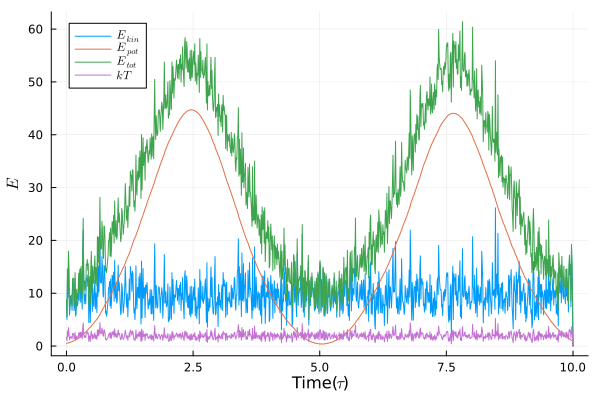

In [27]:
plot(range(0.0, t_end, Nt),
    [BussiSim0.Ekin,
        BussiSim0.Epot,
        BussiSim0.Etot,
        BussiSim0.kT],
    xlabel = L"""Time($\tau$)""", ylabel = L"""$E$""", labels=Elabels)

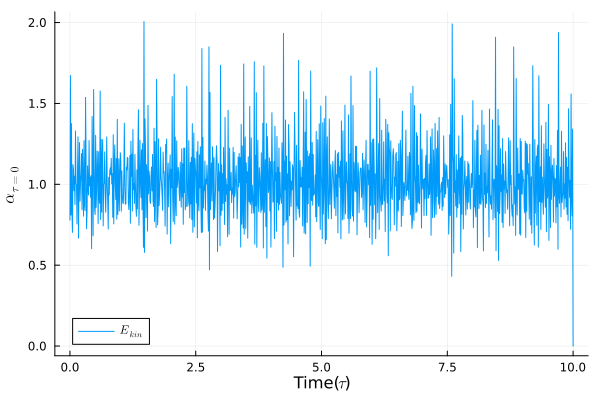

In [28]:
# Plot the alpha rescaling values to see what is going on...
plot(range(0.0, t_end, Nt), alpha_bussi0, xlabel = L"""Time($\tau$)""", ylabel = L"""$\alpha_{\tau = 0}$""", labels=Elabels)

What about turning up the decay value of $\tau$?

In [29]:
# Reset the Bussi simulation
BussiSim1.X[1,:] = InitialValueSim.X[1,:];
BussiSim1.P[1,:] = InitialValueSim.P[1,:];
tau_bussi = 20.0*dt;
alpha_bussi1 = zeros(Nt);
# Make this consistent by setting a random seed every time we evaluate this cell!
Random.seed!(71298);
for istep in 1:Nt-1
    # Compare to the Berendsen thermostat
    alpha_bussi1[istep] = VelocityVerletSHOBussi!(BussiSim1, m, k, 1.0, tau_bussi, dt, istep);
end

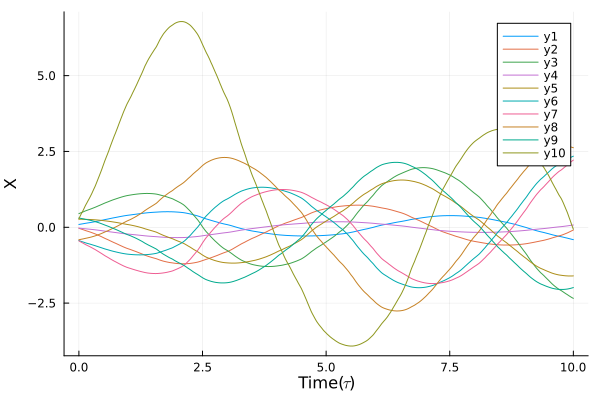

In [30]:
plot(range(0.0, t_end, Nt), BussiSim1.X, xlabel = L"""Time($\tau$)""", ylabel = "X")

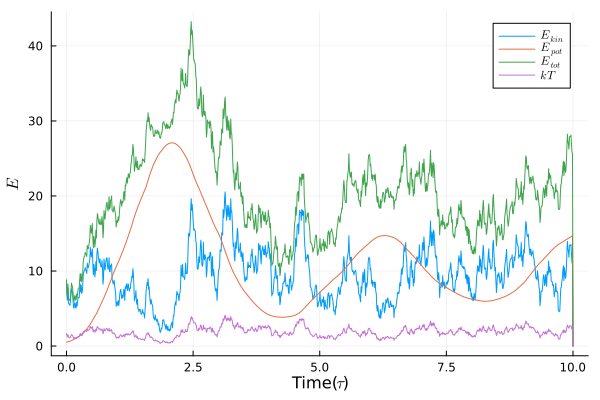

In [31]:
plot(range(0.0, t_end, Nt),
    [BussiSim1.Ekin,
        BussiSim1.Epot,
        BussiSim1.Etot,
        BussiSim1.kT],
    xlabel = L"""Time($\tau$)""", ylabel = L"""$E$""", labels=Elabels)

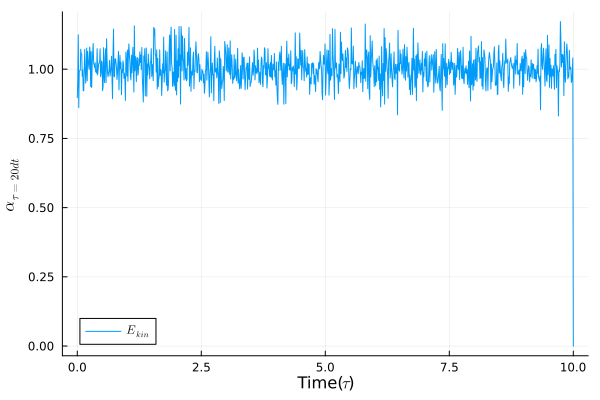

In [32]:
# Plot the alpha rescaling values to see what is going on...
plot(range(0.0, t_end, Nt), alpha_bussi1, xlabel = L"""Time($\tau$)""", ylabel = L"""$\alpha_{\tau = 20dt}$""", labels=Elabels)